In [150]:
import numpy as np
import pandas as pd
import csv
from utils import new_columns, final_columns,columns_encoding
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# What's my age again?
This notebook contains a basic model to predict if a person is over or under 18 years old based on some questions.

Firstly we need some training data. This must be simulated based upon a small set of "tuning" data. Much like in particle physics, our model must be simulated based upon some previous observation.

In [139]:
#First we load in the data from our questionaires
question_data = pd.read_csv("data/MachineLearningAlgorithms-8.csv")
question_data = question_data.dropna() #Removes any rows in the data where there are answers missing
question_data.head() #Gives us a view of the first 5 rows of the data

,Timestamp,1. What is your musical taste? Select any genre that you enjoy. Pick as many as you like.,2. How do you listen to music?,3. What is your film taste? Select any movie that you enjoyed watching. Pick as many as you like.,4. What is your TV show taste? Select any TV series that you enjoyed watching. Pick as many as you like.,5. What are your TV viewing habits?,6. Which of the following social media apps do you regularly use? Pick as many as you like.,7. How many hours a week do you spend on your smart phone?,8. What is your preferred payment method in shops for amounts less than £20?,9. How old are you?
0,2019/06/19 5:34:02 PM GMT+1,Rock;Country;Pop;Indie;Electronic;Hip-hop/Rap,I mostly use Spotify or another music streamin...,Harry Potter series;Love Actually;Toy Story se...,Friends;Only Fools and Horses;Doctor Who;Gavin...,"I mostly watch TV series online (computer, tab...",Facebook;Twitter;WhatsApp;Instagram;LinkedIn,Between 5 and 10 hours,I mostly use Apple Pay or Android Pay or Samsu...,25
1,2019/06/19 5:37:30 PM GMT+1,Pop;Indie;Hip-hop/Rap,I mostly use Spotify or another music streamin...,Star Wars series;Harry Potter series;Love Actu...,Friends;Gavin and Stacey,"I mostly watch TV series online (computer, tab...",Facebook;Twitter;WhatsApp;Instagram,Between 20 and 30 hours,I mostly use Apple Pay or Android Pay or Samsu...,23
2,2019/06/19 5:40:40 PM GMT+1,Classical;Rock;Pop;Indie,I mostly use Spotify or another music streamin...,Star Wars series,Friends;Game of Thrones,I don't really watch TV programs,Twitter;WhatsApp;Instagram,Between 10 and 20 hours,I mostly use cash,31
3,2019/06/19 5:49:52 PM GMT+1,Electronic;Hip-hop/Rap,I mostly use Spotify or another music streamin...,Star Wars series;Harry Potter series;Love Actu...,Friends;Only Fools and Horses;Downtown Abbey;G...,"I mostly watch TV series online (computer, tab...",Facebook;WhatsApp;Instagram;LinkedIn,Between 10 and 20 hours,I mostly use cards,25
4,2019/06/19 5:54:18 PM GMT+1,Classical;Rock;Electronic;Hip-hop/Rap,I mostly use Spotify or another music streamin...,Star Wars series;Toy Story series;2001 Space O...,Game of Thrones,"I mostly watch TV series online (computer, tab...",Twitter,Between 10 and 20 hours,I mostly use cards,32


## Data preprocessing
Now we need to convert the questionnaire into a more useful fromat for processing. This requires turning each multiple choice question into a binary question. For example, the question "What is your preferred payment method in shops for amounts less than £20?" has three possible answers: 
- I mostly use cash
- I mostly use cards
- I mostly use Apple Pay or Android Pay or Samsung Pay.

Instead of being one column for this question, it will become three; cash, cards, apple_pay. Each of these columns will then be either 1 or 0 depending on the users answer. This is much easier for machines to deal with than words.

In [142]:
#Function to split into binary features. column names is a dictionary which maps each answer to
#a new column name. This is stored in utils.py
def convert_to_binary_features(dataframe, column_names):
    temp_rows = []
    for i,row in dataframe.head(n=200).iterrows():
        temp_dict = {key: 0 for key in column_names.values()}
        for i,col in row[1:9]:
            for response in column_names:
                if response in col:
                    temp_dict[column_names[response]] = 1
        if row["9. How old are you?"] >=18:
            temp_dict["9_over18"] = 1
        temp_rows.append(temp_dict)
    
    binary_df = pd.DataFrame(temp_rows)
    return binary_df

In [143]:
binary_question_data = convert_to_binary_features(question_data, final_columns)

The data in this format will make it easy to do some analysis but it isn't the nicest to make plots. What we will do is make another dataframe to make things easier to plot.

In [145]:
#Function to convert data into an easy format to plot
def convert_to_plotting_df(dataframe, columns_encoding):
    plotting_question_data = dataframe.copy()
    for i,row in plotting_question_data.iterrows():
        if row["9. How old are you?"] >=18:
            row["Over 18?"] = 1
        else:
            row["Over 18?"] = 0
        for col in row.keys()[1:9]:
            plotting_question_data.at[i,col] = plotting_question_data.at[i,col].split(";")
            temp_list = []
            for element in plotting_question_data.at[i,col]:
                temp_list.append(columns_encoding[element])
            plotting_question_data.at[i,col] = temp_list
            
    return plotting_question_data
# questions = {}
# for i in range(1,9):
#     questions.update({i:[col for col in list(final_columns.values()) if str(i)+"_" in col]})



In [146]:
plotting_question_data = convert_to_plotting_df(question_data, columns_encoding)

## Plotting
Now its time to plot some data! Using a newly created dataframe ,`plotting_question_data`, we can plot histograms of our data. We want to plot a comparison of the answers from people under 18 and over 18. 


In [147]:
def sns_plot_hist(df, column_name):
    import re
    inv_columns = {v: k for k, v in final_columns.items()}
    question_number = int(re.findall('\d+', column_name )[0])
    x_titles = [inv_columns[x] for x in questions[question_number]]
    x_titles = [re.sub("(.{10})", "\\1-\n", label, 0, re.DOTALL) for label in x_titles]

    over_18_frame = df[df["Over 18"] == 1]
    under_18_frame = df[df["Over 18"] == 0]
    over_18_stack = pd.DataFrame(over_18_frame[column_name].values.tolist(), index=over_18_frame.index).stack()
    under_18_stack = pd.DataFrame(under_18_frame[column_name].values.tolist(), index=under_18_frame.index).stack()
    bins = np.arange(len(questions[question_number])+1)-.5
    plt.figure(figsize=(12,8))
    sns.set()
    sns.set_style("darkgrid")
    sns.set_context("talk")
    sns.distplot(over_18_stack, kde = False, bins=bins, norm_hist=True, 
                      label="Over 18")
    sns.distplot(under_18_stack, kde = False, bins=bins, norm_hist=True,
                     label="Under 18")
    plt.xticks(np.arange(len(questions[question_number])), x_titles, 
               rotation='vertical')
    plt.title(column_name)
    plt.ylabel("Normalised to responses (a.u.)")
    plt.legend()
    plt.subplots_adjust(bottom=0.2)
    plt.savefig("{0}.pdf".format(column_name.replace(" ","_").replace(".", "").replace("?","")))

    

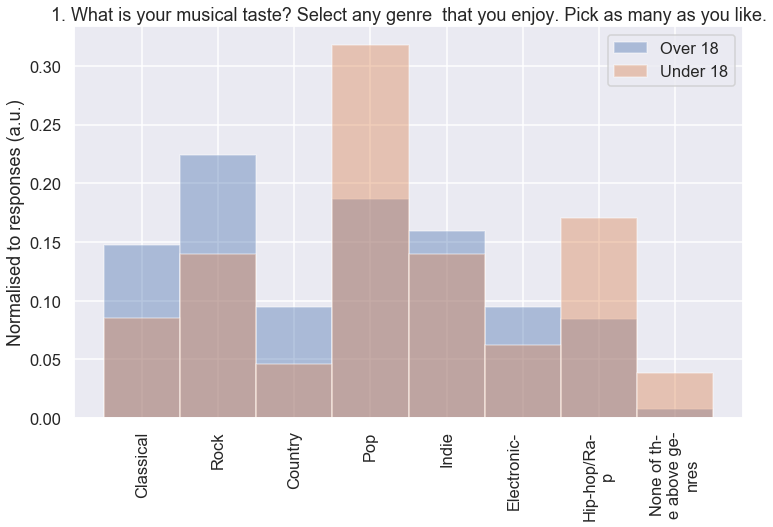

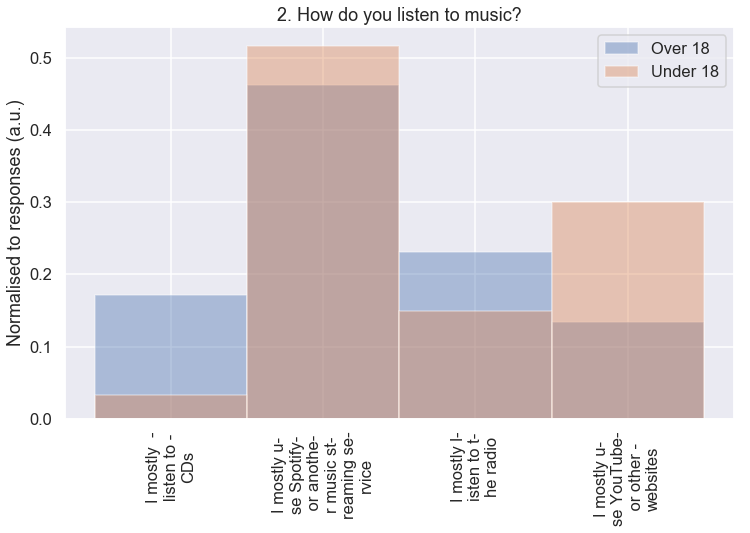

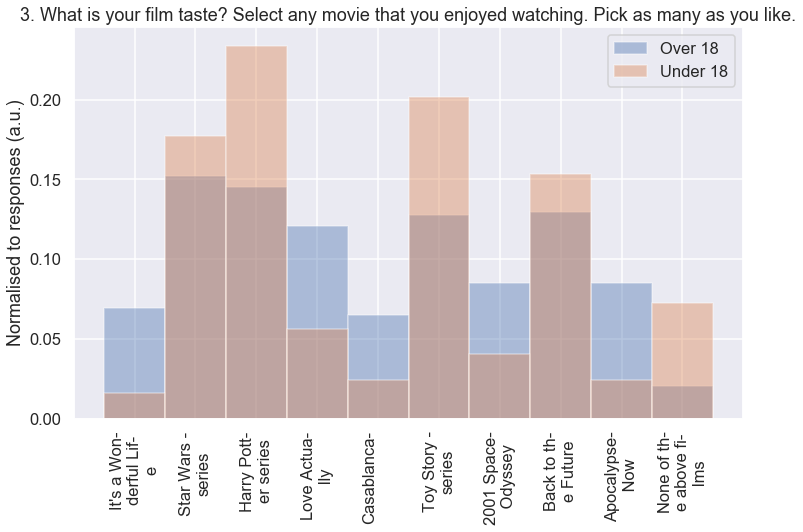

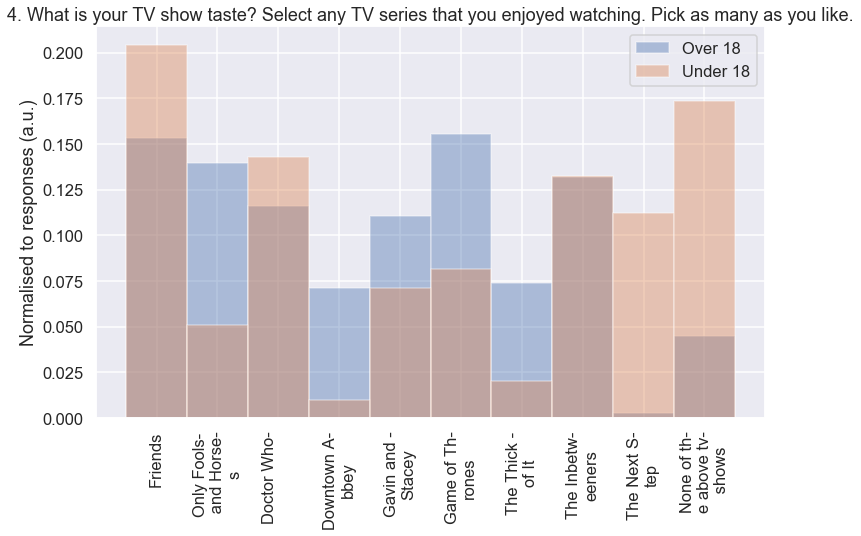

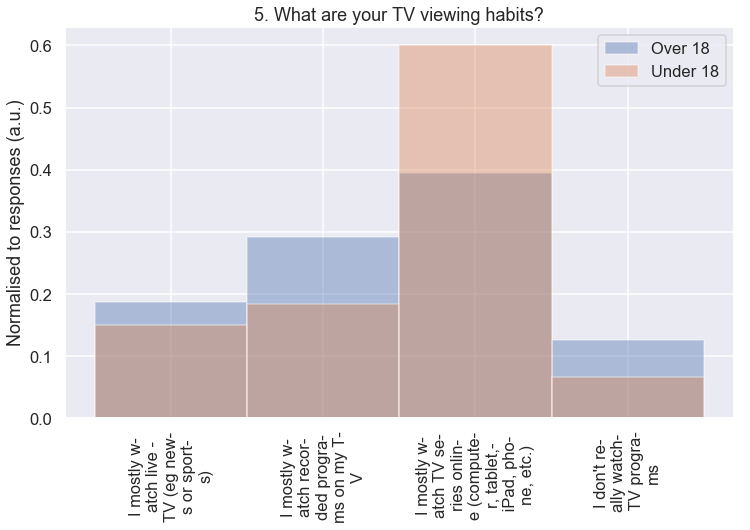

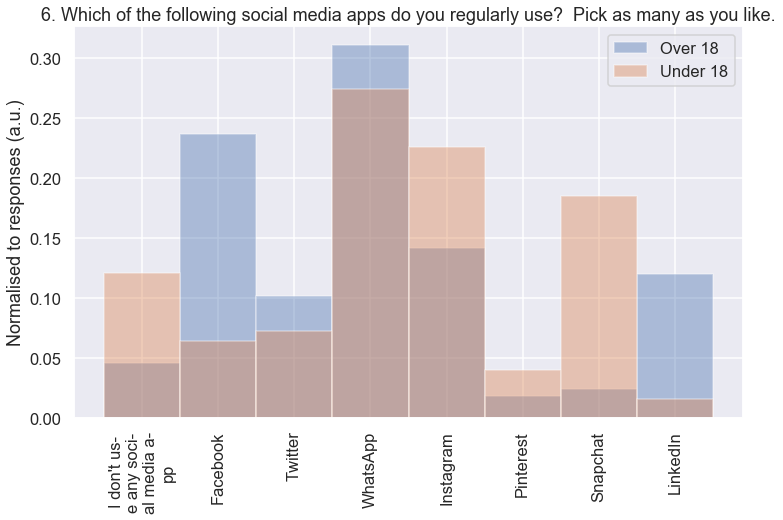

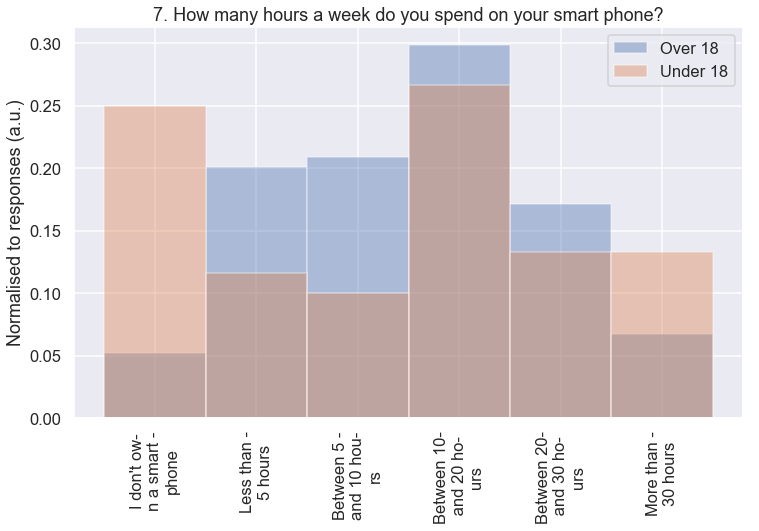

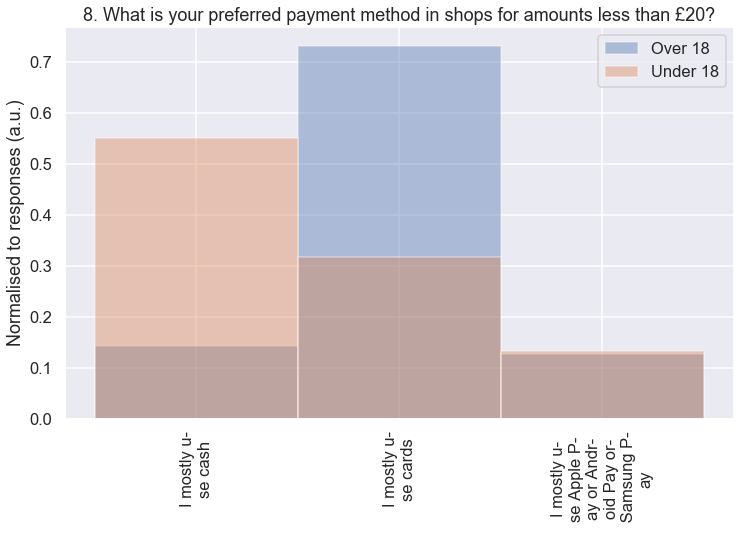

In [148]:
for col in plotting_frame.columns[1:9]: #Loop over all of questions and produce and save a plot
     sns_plot_hist(plotting_frame, col)


## Analysis
Now that we have produced some plots and have a feeling for the data, it's time to do some analysis. First of all we need to split our data in to two categories; training data and test data. The training data is what we will use to train our model and the test data is then used to see how well the model performs on data it hasn't seen before. 

In our case we will split the data 75% training and 25% test.

In [75]:
test_fraction = 0.25
train_data, test_data = train_test_split(binary_question_data, test_size=test_fraction)

Now we have two new dataframes `train_data` and `test_data`. Now we want to split into our inputs `X` and our outputs `y`. In this case `X` will be a vector containing the responses to the questions and `y` will be 1 or 0 indicating whether the person is over 18 or not.

In [152]:
def split_data(train_data, test_data, names):
    X_train = train_data[names]
    y_train = np.array(train_data['9_over18'])

    X_test = test_data[names]
    y_test  = np.array(test_data['9_over18'])
    
    return (X_train, X_test, y_train, y_test)


In [167]:
columns_to_use = list(final_columns.values())[:53]
X_train, X_test, y_train, y_test,  = split_data(train_data, test_data, columns_to_use)

It will be interesting to look at which questions give the best discrimination between under and over 18 year olds. The function below outputs a list of the top 10 discriminating questions.

In [168]:
# Feature extraction
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features


              Specs      Score
42       6_snapchat  16.443923
50           8_cash  13.505713
30    4_thenextstep  13.321804
37       6_facebook  12.670407
23      4_onlyfools  10.104619
43       6_linkedin   9.177300
7            1_none   8.619548
27  4_gameofthrones   7.712002
44           7_none   7.021498
25   4_downtonabbey   6.376256


Another useful plot to make is to look at the correlation matrix. This gives us information on which features(the question answers in our case) are correlated. 

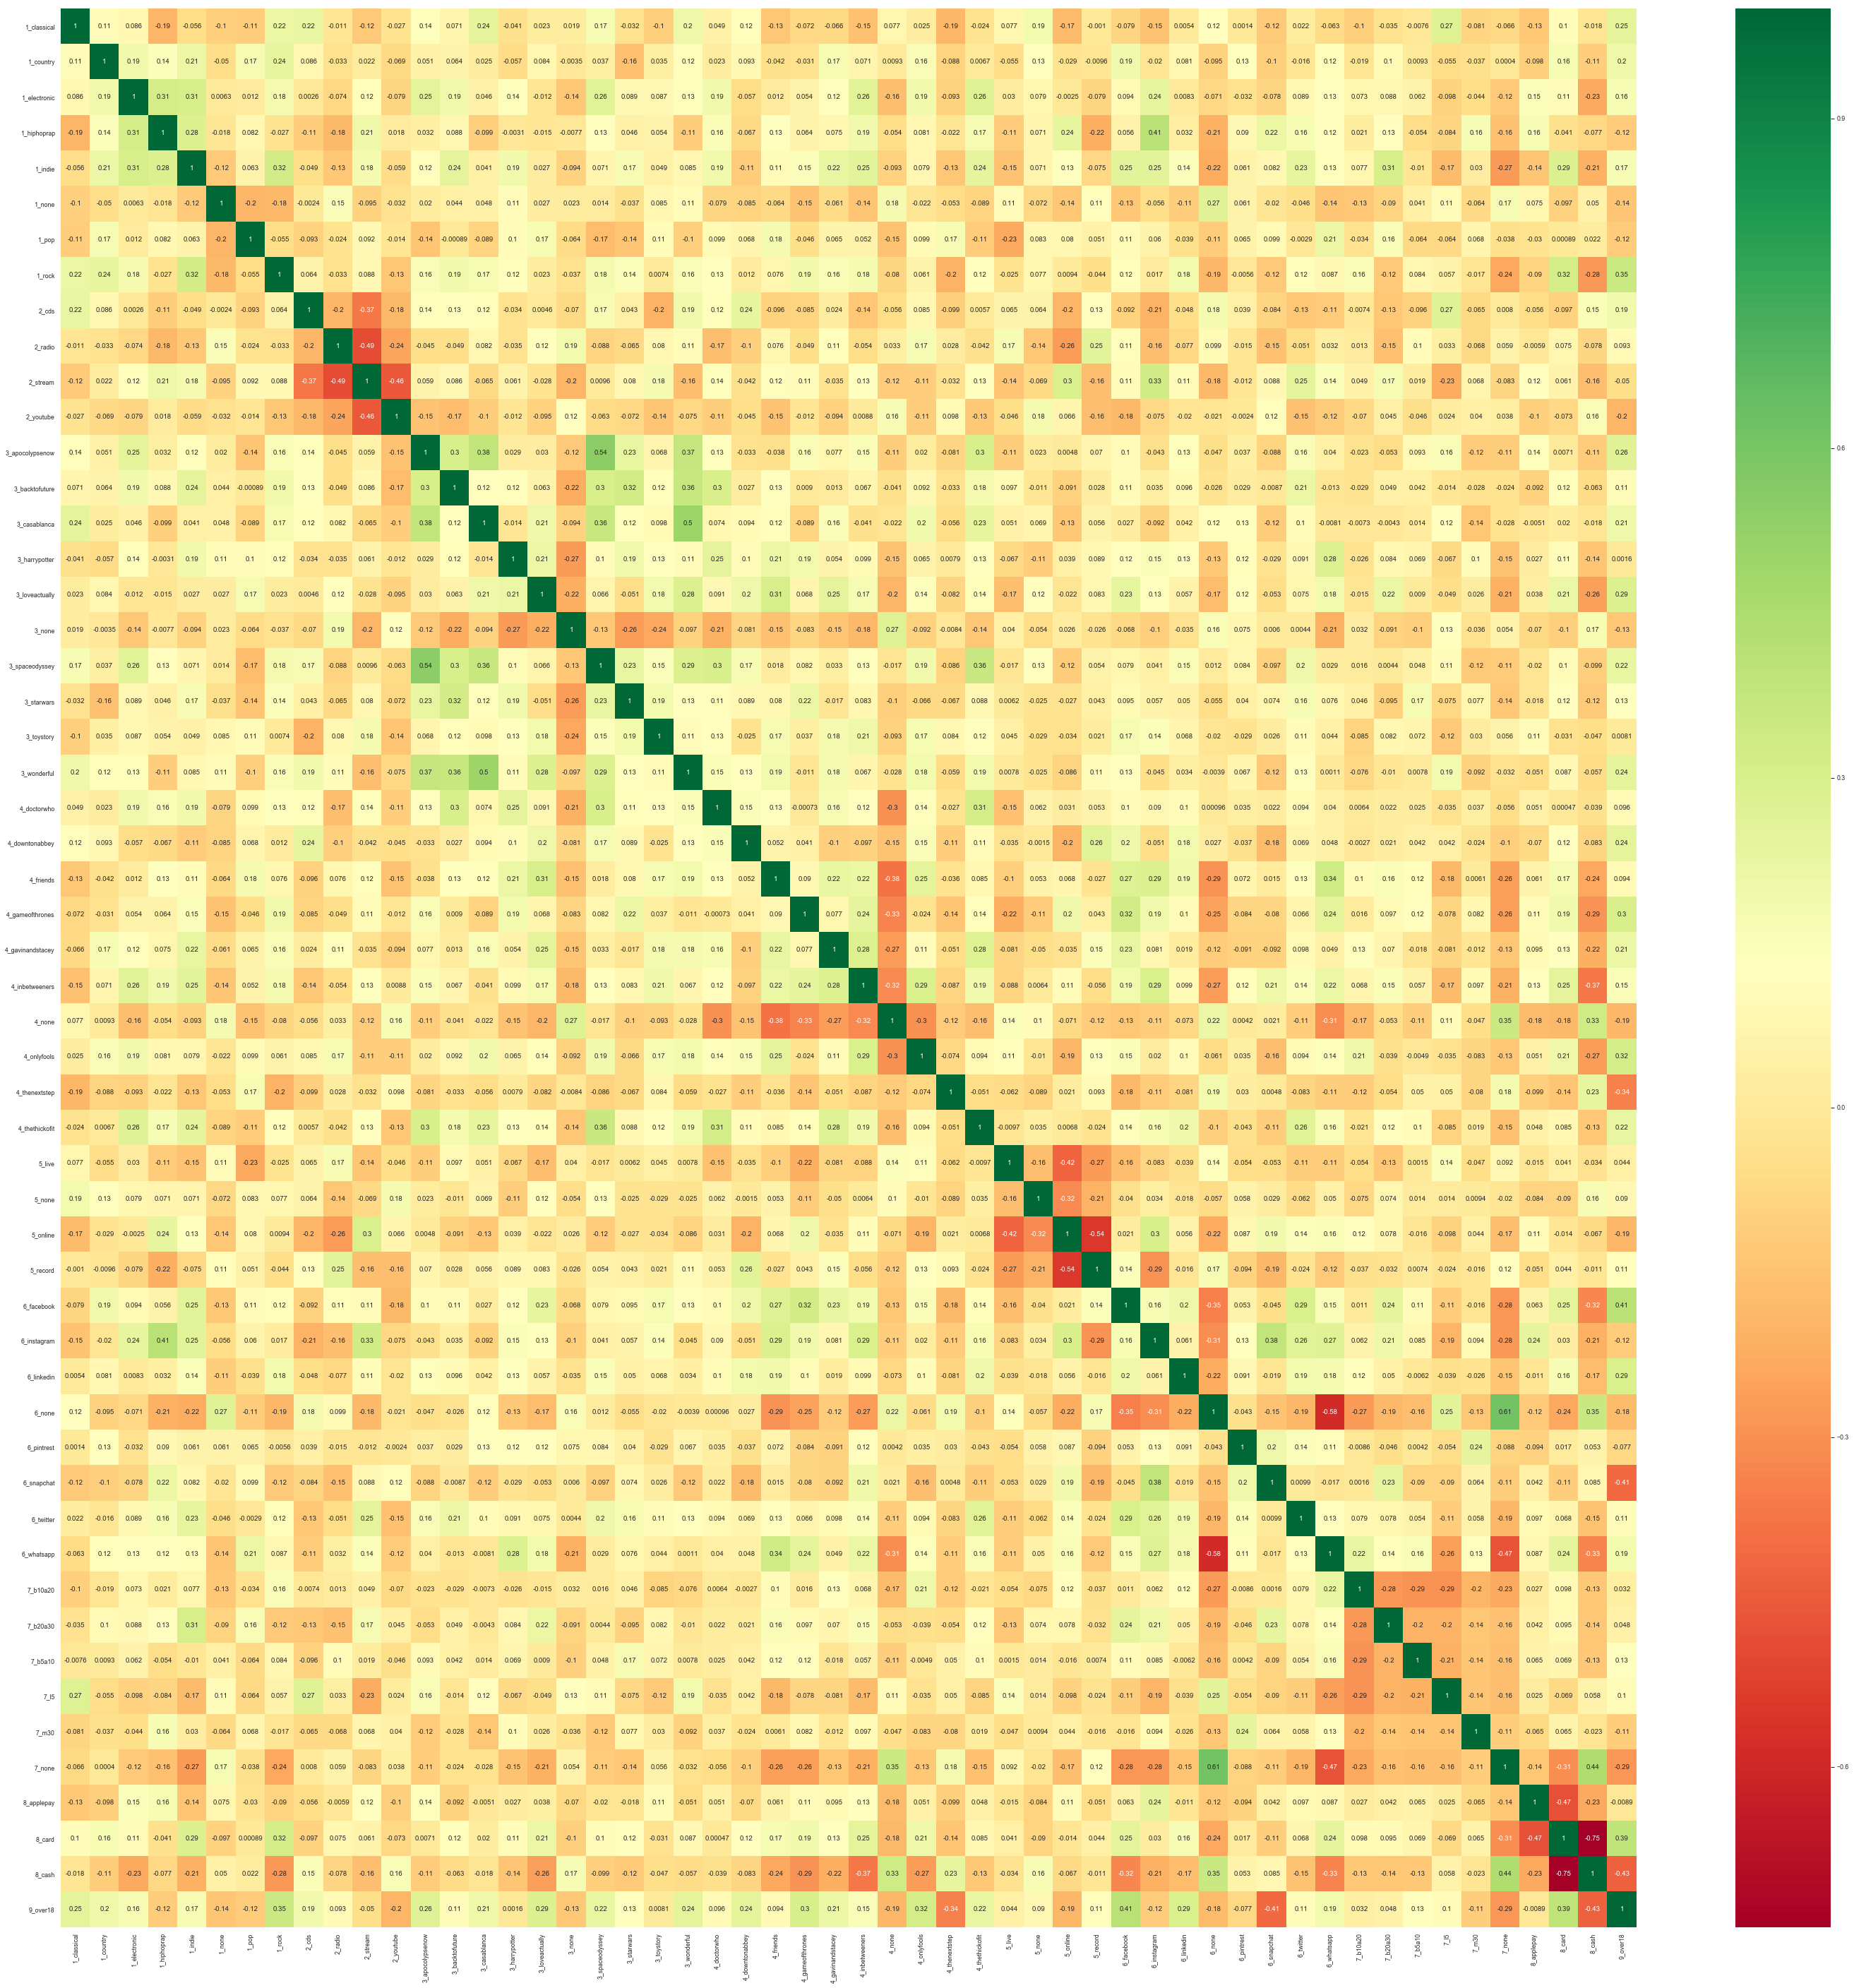

In [169]:
corrmat = binary_question_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(50,50))
sns.set_context("paper")
g=sns.heatmap(new_questions_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.savefig("correlation.pdf")

## Building our BDT model
We will now build our BDT model! We are using the scikit learn package which has a number of built in models. In our case for the decision tree, we use `DecisionTreeClassifier` which has a number of hyper paramaters which can be tuned. For the boosting, we use `DecisionTreeClassifier` which takes our decision tree as an input. Again this has tunable hyperparameters. 


In [193]:
dt  = DecisionTreeClassifier(max_depth=5,
                             min_samples_leaf=25,
                             max_features=10,
                             splitter = "best",
                             criterion="gini")

ada = AdaBoostClassifier(dt, 
                         n_estimators=100, 
                         random_state=1)

#Paramaters to search over
params = {'base_estimator__min_samples_leaf': [10,25,50],
          'base_estimator__max_depth': [4,5,10],
          'base_estimator__max_features': [3,5,7,10],
          'n_estimators' : [25,30,50,100]
         }

We now perform a search over the above values of the hyperparameters to find the combination which gives us the best performance.

In [194]:
print("*** TRAINING ***")
rcv = GridSearchCV(ada, params, verbose=1, n_jobs=-1)
rcv.fit(X_train, y_train)

print("Best set of parameters: %s" % rcv.best_params_)

adabest = rcv.best_estimator_
adabest.fit(X_train, y_train)

print("Training set score: %f" % adabest.score(X_train, y_train))      
print("Test set score:     %f" % adabest.score(X_test,  y_test))

*** TRAINING ***
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.3s


Best set of parameters: {'base_estimator__max_depth': 4, 'base_estimator__max_features': 3, 'base_estimator__min_samples_leaf': 25, 'n_estimators': 25}
Training set score: 0.931034
Test set score:     0.877551


[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   16.5s finished


In [195]:
fit = adabest.fit(X_train,y_train)
predict = fit.predict(X_test)

Now have trained our model it's time to use it. We can now use our test data to see how it performs!

In [196]:
def predict_proba(ada, X_test):
    trees   = ada.estimators_
    weights = ada.estimator_weights_
    scores  = [((2*t.predict(X_test)-1)*w).tolist() for (t, w) in zip(trees, weights)]
    F = [0.0]*len(X_test)
    for j in range(len(X_test)):
        for i in range(len(trees)):
            F[j] += scores[i][j]
    F = np.array(F)
    p = 1.0/(1 + np.exp(-2*F))
    return p

In [197]:
p = predict_proba(adabest, X_test)

In [198]:
def plotDistribution(p, y_test, fgsize=(12, 6), arange=(0, 1), nbins=25):
 
    p_u18  = list(map(lambda x: x[0], filter(lambda x: x[-1], zip(p, y_test < 0.5))))
    p_o18 = list(map(lambda x: x[0], filter(lambda x: x[-1], zip(p, y_test > 0.5))))
    
    
    # set size of figure
    plt.figure(figsize=fgsize)
    plt.hist(p_u18,
             bins=nbins,
             color=(1,0,0),
             alpha=0.3,
             range=arange, 
            normed=True,
             label='Under 18')
    plt.legend(loc='upper left',
              fontsize=18) 
    
    plt.hist(p_o18,
             bins=nbins, 
             color=(0,1,0),
             alpha=0.3,
             range=arange, 
             normed=True, 
             label='Over 18')
    plt.legend(loc='upper left',
              fontsize=18) 
    
    plt.savefig("BDT_discriminant.png")
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


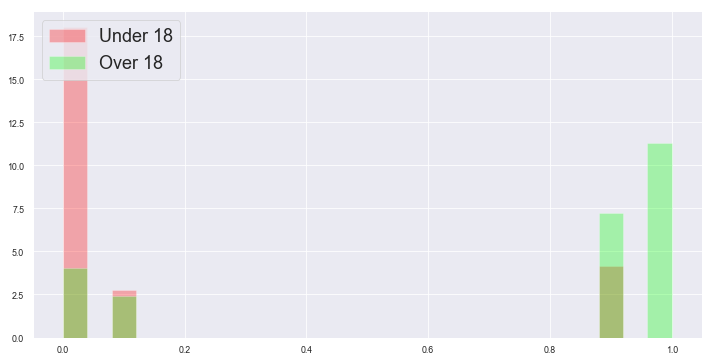

In [199]:
plotDistribution(p, y_test)

In [200]:
def plotROC(y_test, p):
    bad, good, _ = roc_curve(y_test, p)
    roc_auc = auc(bad, good)
    plt.figure(figsize=(8, 8))

    plt.plot(bad, good, color='red',
             lw=2, label='ROC curve, AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('fraction under 18')
    plt.ylabel('fraction over 18')
    plt.legend(loc="lower right", fontsize=18)
    plt.show()


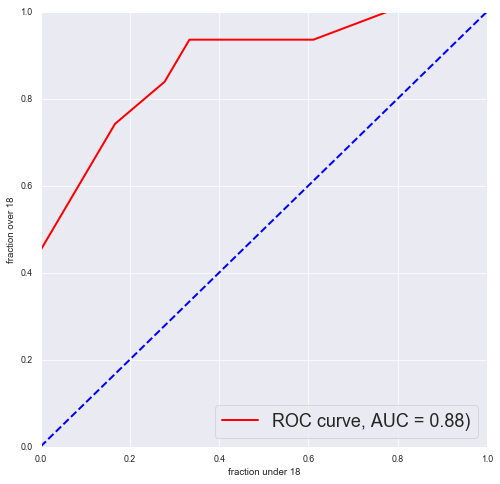

In [201]:
plotROC(y_test, p)

In [192]:
import os
len(trees)
def draw_tree(tree, n):
    out_name = "trees/tree_{0}".format(n)
    export_graphviz(tree, 
                out_file='{0}.dot'.format(out_name), 
                feature_names = columns_to_use,
                class_names   = ['under 18', 'over 18'],
                rounded = True, proportion = False, filled = True)
    os.system("dot -Tpng {0}.dot -o {0}.png -Gdpi=300".format(out_name))


trees = adabest.estimators_
for i,tree in enumerate(trees):
    draw_tree(tree,i)

os.system("rm trees/*.dot")

0